## Graph Classification Pipeline

File : graph_classify_cv_pipeline.ipynb

Author : Billy Carson

Date : 01-15-2021

Last modified : 02-08-2021

> Description : Graph classification cross-validation pipeline using Deep Graph Library.


### Import libraries and modules

In [1]:
# Import libraries and modules
import time
import numpy as np
import networkx as nx
import dgl
from dgl.data import TUDataset
from dgl.data.utils import split_dataset
from dgl.nn.pytorch import conv
import torch
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss
from torch.optim import SGD, RMSprop, Adam
from torch.utils.data import DataLoader, Subset
import torch.nn.functional as F

# Import model, data, and training modules
from load_data import *
from model import *
from train import *
from misc_utils import *

# Set random state
random_state = 0


DGL backend not selected or invalid.  Assuming PyTorch for now.
Using backend: pytorch


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


### Load data

In [2]:
# Load enzyme dataste
dataset = TUDataset("ENZYMES")

# Remove samples zero in-degree nodes
# dataset = remove_zero_in_degree_samples(dataset=dataset)

# Convert labels to PyTorch tensor
dataset.graph_labels = torch.tensor(dataset.graph_labels)

# Cast the node attributes in float format
for i in range(len(dataset)):
    dataset[i][0].ndata['node_attr'] = dataset[i][0].ndata['node_attr'].float() 


Extracting file to /home/billy/.dgl/ENZYMES


<ipython-input-2-5eb91a08291d>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset.graph_labels = torch.tensor(dataset.graph_labels)


### Display example graph information


Number of graphs:  600
Number of classes: 6

Example graph sample information:

Graph(num_nodes=37, num_edges=168,
      ndata_schemes={'node_labels': Scheme(shape=(1,), dtype=torch.int64), 'node_attr': Scheme(shape=(18,), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)})
tensor([5])


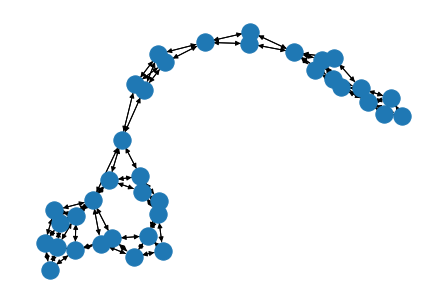

In [3]:
# Display dataset information
print('\nNumber of graphs:  %d' % len(dataset))
print('Number of classes: %d\n' % len(np.unique(dataset.graph_labels)))

# Example graph sample
graph, label = dataset[0]
print('Example graph sample information:\n')
print(graph)
print(label)

# Use NetworkX to illustrate example graph
nx.draw_spring(graph.to_networkx())


### K-fold splits and repetitions

In [4]:
# Get K-fold splits
n_folds = 4
kfold = KFold(labels=np.array(dataset.graph_labels), n_folds=n_folds, splits_as_arrays=True, random_state=random_state)
kfold_splits = kfold.get_splits()


### Enable GPU compute

In [6]:
# Enable GPU compute
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# Display device
print('\nDevice:  %s\n' % (str(device)))



Device:  cuda:0



### Model instantiation function

In [7]:
# # Model parameters
# input_node_dim = 18
# latent_node_dim = 64
# output_dim = 6

# # Model instantiation function
# def model_fn():
#     """
#     Description
#     -----------
#     Model instantiation function. Resets model parameters at the beginning of each cross-validation fold.

#     Parameters
#     ----------
#     N/A

#     Returns
#     -------
#     model : torch.nn.Module; randomly initialized PyTorch model
#     """
    
#     # Change this line depending on what type of model to use
#     model = GCN(input_node_dim=input_node_dim, latent_node_dim=latent_node_dim, output_dim=output_dim)

#     # Return model
#     return model

# Model parameters
input_node_dim = 18
latent_node_dim = 64
n_classes = 6
n_layers = 3
n_heads = 6
activation = F.relu
feat_drop = 0.2
attn_drop = 0.2
neg_slope = 0.2
residual = False
amp = False

# Model instantiation function
def model_fn():
    """
    Description
    -----------
    Model instantiation function. Resets model parameters at the beginning of each cross-validation fold.

    Parameters
    ----------
    N/A

    Returns
    -------
    model : torch.nn.Module; randomly initialized PyTorch model
    """
    
    # Change this line depending on what type of model to use
    model = GAT(input_node_dim=input_node_dim, latent_node_dim=latent_node_dim, n_classes=n_classes,
                n_layers=n_layers, n_heads=n_heads, activation=activation, feat_drop=feat_drop, attn_drop=attn_drop,
                neg_slope=neg_slope, residual=residual, amp=amp)

    # Return model
    return model



### Instantiate training objects

In [8]:
# Instantiate model
# model = GCN(input_node_dim=18, latent_node_dim=64, output_dim=6).to(device)

# Instantiate loss
loss_fn = torch.nn.CrossEntropyLoss()

# Instantiate optimizer
lr = 8e-4
optimizer_class = Adam
# optimizer_class = RMSprop

# Define training parameters
n_reps = 3                # number of repetitions
n_epochs = 3000           # number of training epochs
batch_size = 600          # batch size
checkpoint_path = 'model_checkpoints/gnn_checkpoint.pt'    # model checkpoint save path
amp = True                # automatic mixed precision training if True
progress_step = 200       # how often to display training progress
verbose = 2               # controls how much is printed / displayed


### Cross-validation loop

In [9]:
# Start cross-validation time
start_time = time.time()

# K-fold cross-validation function
cross_val(model_fn=model_fn,
          dataset=dataset,
          loss_fn=loss_fn,
          optimizer_class=optimizer_class,
          kfold_splits=kfold_splits,
          collate_func=collate_graphs,
          n_folds=n_folds,
          n_epochs=n_epochs,
          n_reps=n_reps,
          lr=lr,
          device=device,
          batch_size=batch_size,
          checkpoint_path=checkpoint_path,
          amp=amp,
          progress_step=progress_step,
          verbose=verbose)

# Stop cross-validation time
end_time = time.time()

# Display cross-validation time
print('Time to complete cross-validation:  %s\n' % get_converted_time(end_time - start_time))


Repetition 1:

  Fold 1:

    Epoch 00001 | train loss: 6.1298 | val. loss: 2.8083 | train acc.: 0.1846 | val acc.: 0.1824
    Epoch 00200 | train loss: 1.5454 | val. loss: 1.9641 | train acc.: 0.3725 | val acc.: 0.2365
    Epoch 00400 | train loss: 1.3929 | val. loss: 2.3677 | train acc.: 0.4597 | val acc.: 0.3041
    Epoch 00600 | train loss: 1.1626 | val. loss: 2.1386 | train acc.: 0.5134 | val acc.: 0.3243
    Epoch 00800 | train loss: 1.0553 | val. loss: 2.0140 | train acc.: 0.6309 | val acc.: 0.3649
    Epoch 01000 | train loss: 0.8718 | val. loss: 2.1564 | train acc.: 0.6946 | val acc.: 0.4392
    Epoch 01200 | train loss: 0.7656 | val. loss: 2.1898 | train acc.: 0.7315 | val acc.: 0.3851
    Epoch 01400 | train loss: 0.5614 | val. loss: 2.3057 | train acc.: 0.8154 | val acc.: 0.4257
    Epoch 01600 | train loss: 0.4479 | val. loss: 2.3390 | train acc.: 0.8423 | val acc.: 0.4865
    Epoch 01800 | train loss: 0.4013 | val. loss: 2.3923 | train acc.: 0.8624 | val acc.: 0.4730
    